### Libraries

In [27]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, TimeDistributed, Input
from tensorflow.keras.models import load_model

### MLFlow settings

Setup MLflow:

In [28]:
import os
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_city_seasonality_test1"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

FuelProphet experiment setup successful!


### My own functions

In [29]:
from functions_laura.Data_processing import resample
from functions_laura.Data_processing import resample_with_seasonality
from functions_laura.Data_cleaning import data_cleaning_datetime

# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

In [30]:
df = pd.read_parquet('../data/hamburg_raw.parquet')
df = data_cleaning_datetime(df)

/Users/laurabrylka/Documents/Git/FuelProphet/functions_laura/Data_cleaning.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df['date'].apply(lambda x: datetime.strptime(x.split("+")[0], "%Y-%m-%d %H:%M:%S"))


### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

Old function without validation - do not use.
***

In [5]:
# ##### FUNCTIONS TO PREPROCESS THE DATA and make plots and checks ##########

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from scipy.stats import gaussian_kde

# #####
# def prepare_forecast_data(df, scaler,
#                             forecast_input_start,
#                             forecast_output_start,
#                             days_input, days_output,
#                             fuel='e5',
#                             window_size=288):
#     """
#     Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

#     Parameters:
#     - df: pandas DataFrame with datetime index
#     - scaler: fitted MinMaxScaler
#     - forecast_input_start: datetime, start of input window
#     - forecast_output_start: datetime, start of output window
#     - days_input: number of days for input
#     - days_output: number of days for prediction
#     - fuel: string, name of the column to use (default: 'e5')
#     - window_size: number of steps per day (default: 288 for 5-min data)

#     Returns:
#     - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
#     ###- forecast_timestamps: list of timestamps corresponding to each prediction###
#     """
#     df = df.copy()
#     df["time_index"] = np.arange(len(df))

#     input_mask = (df.index >= forecast_input_start) & (df.index < forecast_output_start)
#     output_mask = (df.index >= forecast_output_start) & (
#         df.index < forecast_output_start + pd.Timedelta(days=days_output)
#     )

#     input_rows = df[input_mask]["time_index"].values
#     output_rows = df[output_mask]["time_index"].values

#     expected_input_rows = days_input * window_size
#     expected_output_rows = days_output * window_size

#     if len(input_rows) != expected_input_rows:
#         raise ValueError(f"Expected {expected_input_rows} input rows, got {len(input_rows)}")
#     if len(output_rows) != expected_output_rows:
#         raise ValueError(f"Expected {expected_output_rows} output rows, got {len(output_rows)}")

#     start_idx = input_rows[0]
#     end_idx = output_rows[-1] + 1

#     values = df[[fuel]].values
#     scaled_values = scaler.transform(values)
#     forecast_slice = scaled_values[start_idx:end_idx]

#     total_target_steps = expected_output_rows
#     X_forecast = []

#     for i in range(total_target_steps):
#         window = forecast_slice[i:i + window_size]
#         X_forecast.append(window)

#     X_forecast = np.array(X_forecast)  # shape: (288, 288, 1)
#     #forecast_timestamps = df.iloc[output_rows].index.tolist()

#     y_test = df.loc[
#     (df.index >= forecast_output_start) &
#     (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
#     fuel  # or whatever fuel column you're forecasting
#     ].values.reshape(-1, 1)

#     return X_forecast, y_test
# ################################################################################################################
# #### sliding window function:
# def create_sequences(
#         data, 
#         window_size, 
#         target_col_index):
#     """Create sequences for time series prediction.
    
#     Args:
#         data: Scaled input data with shape (samples, features)
#         window_size: Number of time steps to look back
#         target_col_index: Index of the target column to predict
        
#     Returns:
#         X: Input sequences with shape (samples, window_size, features)
#         y: Target values with shape (samples,)
#     """
#     X = []
#     y = []
#     for i in range(len(data) - window_size):
#         # Get sequence of all features
#         sequence = data[i:(i + window_size)]
#         X.append(sequence)
#         # Get next value of target feature
#         target = data[i + window_size, target_col_index]
#         y.append(target)
#     return np.array(X), np.array(y)

# ################################################################################################################
# def preprocess(
#         df = df, 
#         station_uuid = None, 
#         train_start = None, 
#         train_end = None,
#         test_end = None, 
#         fuel = 'e5',
#         input_days = 3,
#         output_days = 1,
#         start_input = None,
#         start_forecast = None,
#         verbose = True):
#     # Filter for station
#     df_one_station = df[df['station_uuid'] == station_uuid] 

#     # resample the df
#     df_one_station = resample(df_one_station)
    
#     # Define train and test
#     train_start = pd.to_datetime(train_start) 
#     train_end = pd.to_datetime(train_end)
#     test_end = pd.to_datetime(test_end)
    
#     # Create train and test df
#     train_df = df_one_station[
#     (df_one_station['datetime'] >= train_start) & 
#     (df_one_station['datetime'] < train_end)
#     ]

#     test_df = df_one_station[
#     (df_one_station['datetime'] >= train_end) & 
#     (df_one_station['datetime'] <= test_end)
#     ]
#     # reduce the data to e5 and datetime
#     train_df = pd.DataFrame({
#         'datetime' : train_df['datetime'],
#         fuel : train_df[fuel]
#     })

#     test_df = pd.DataFrame({
#         'datetime' : test_df['datetime'],
#         fuel : test_df[fuel]
#     })

#     #make a datetime index
#     test_df.set_index('datetime', inplace=True)
#     train_df.set_index('datetime', inplace=True)


#     # scale data minmax
#     scaler = MinMaxScaler()
#     scaler.fit(train_df[[fuel]])
#     scaled_train = scaler.transform(train_df[[fuel]])
#     #scaled_test = scaler.transform(test_df[[fuel]])

#     # using the sliding window function (create_sequences)
#     window_size = 288  # one day of 5-min steps
#     target_col_index = 0  # e5 price is in first column
#     ### here we create X and y #####
#     X, y = create_sequences(scaled_train, window_size, target_col_index) 

#     #preparative code for the forecasting sequence
#     #total_input_steps = input_days * window_size
#     #total_target_steps = output_days * window_size
#      #reduced_scaled_test = scaled_test[-(total_input_steps + total_target_steps):-total_target_steps]

#     ### here we create X_forecast ####
#     start_input = pd.to_datetime(start_input)
#     start_forecast = pd.to_datetime(start_forecast)
#     X_forecast, y_test = prepare_forecast_data(test_df, forecast_input_start=start_input, forecast_output_start=start_forecast, days_input=input_days, days_output=output_days, scaler=scaler)

#     # Add sanity check for input days
#     actual_input_days = (start_forecast - start_input).days
#     if actual_input_days != input_days:
#             print("\n⚠️ WARNING: Input days mismatch!")
#             print(f"Configured input_days: {input_days}")
#             print(f"Actual days between start_input and start_forecast: {actual_input_days}")
#             print(f"start_input: {start_input}")
#             print(f"start_forecast: {start_forecast}")
#             print("Please adjust your dates to match the intended input window.")
        

#     if verbose == True:
#         # Plotting the train and test set
#         plt.figure(figsize=(10,6))
#         plt.plot(train_df.index, train_df[fuel], label='Train data', drawstyle='steps-post')
#         plt.plot(test_df.index, test_df[fuel], label='Test data', drawstyle='steps-post')
        
#         plt.xlabel('Date')
#         plt.ylabel(f'{fuel} Price')
#         plt.title('Train and Test Data')
#         plt.legend()
        
#         # Rotate x-axis labels for better readability
#         plt.xticks(rotation=45)
        
#         # Adjust layout to prevent label cutoff
#         plt.tight_layout()
        
#         plt.show()
        
#         # plot test data
        
#         # Plot Test
#         plt.figure(figsize=(14, 5))
#         plt.plot(test_df[fuel], label=f'True Test {fuel}', drawstyle='steps-post')
#         plt.title("Test Set - True")
#         plt.xlabel("Time Step")
#         plt.ylabel(f"{fuel} Price")
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
#         # First, let's verify our actual data range
#         print("Test set date range:")
#         print(f"Start: {test_df.index.min()}")
#         print(f"End: {test_df.index.max()}")
        
#         # Print shapes of X and y training data to verify
#         print(f"Input shape: {X.shape}")  # Should be (samples, 288, 2)
#         print(f"Target shape: {y.shape}") # Should be (samples,)
        
#         # check for overlapping timestamps
#         train_times = set(train_df.index)
#         test_times = set(test_df.index)
#         overlap = train_times.intersection(test_times)
#         print(f"Overlap: {len(overlap)}")
        
#         # check test and train distribution
#         x_train = train_df["e5"].dropna()
#         x_test = test_df["e5"].dropna()
        
#         kde_train = gaussian_kde(x_train)
#         kde_test = gaussian_kde(x_test)
        
#         x_vals = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 1000)
#         plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
#         plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
#         plt.legend()
#         plt.title(f"KDE of {fuel} in Train vs Test")
#         plt.xlabel(f"{fuel} Value")
#         plt.ylabel("Density")
#         plt.grid(True)
#         plt.show()
        
#         #Print forecast setup
#         print("\nForecast setup:")
#         print(f"Using data from {start_input} to {start_forecast}")
#         print(f"To predict day: {test_end}")

#         # Calculate time difference using pd.Timedelta
#         time_diff = pd.Timedelta(days=input_days)
#         hours = time_diff.total_seconds() / 3600
#         days = time_diff.days
        
#         print("\nTime window analysis:")
#         print(f"Time difference: {time_diff}")
#         print(f"Hours: {hours:.1f}")
#         print(f"Days: {days}")
#         print(f"Number of 5-min intervals: {time_diff.total_seconds() / 300:.0f}")
    
#     return X, y, X_forecast, y_test, scaler, scaled_train, test_df 


***
New function to preprocess the data including the validation set:

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde


###################################################################################################
def prepare_forecast_data(df_test, scaler,
                            forecast_input_start,
                            forecast_output_start,
                            days_input, days_output,
                            fuel='e5',
                            window_size=288):
    """
    Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

    Parameters:
    - df: pandas DataFrame with datetime index
    - scaler: fitted MinMaxScaler
    - forecast_input_start: datetime, start of input window
    - forecast_output_start: datetime, start of output window
    - days_input: number of days for input
    - days_output: number of days for prediction
    - fuel: string, name of the column to use (default: 'e5')
    - window_size: number of steps per day (default: 288 for 5-min data)

    Returns:
    - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
    ###- forecast_timestamps: list of timestamps corresponding to each prediction###
    """
    df = df_test.copy()
    df.index = pd.to_datetime(df.index)
    df["time_index"] = np.arange(len(df))

    input_mask = (df.index >= forecast_input_start) & (df.index < forecast_output_start)
    output_mask = (df.index >= forecast_output_start) & (
        df.index < forecast_output_start + pd.Timedelta(days=days_output)
    )

    input_rows = df[input_mask]["time_index"].values
    output_rows = df[output_mask]["time_index"].values

    expected_input_rows = days_input * window_size
    expected_output_rows = days_output * window_size

    if len(input_rows) != expected_input_rows:
        raise ValueError(f"Expected {expected_input_rows} input rows, got {len(input_rows)}")
    if len(output_rows) != expected_output_rows:
        raise ValueError(f"Expected {expected_output_rows} output rows, got {len(output_rows)}")

    start_idx = input_rows[0]
    end_idx = output_rows[-1] + 1

    values = df[[fuel, 'seasonal_component']].values
    scaled_values = scaler.transform(values)
    forecast_slice = scaled_values[start_idx:end_idx]

    total_target_steps = expected_output_rows
    X_forecast = []

    for i in range(total_target_steps):
        window = forecast_slice[i:i + window_size]
        X_forecast.append(window)

    X_forecast = np.array(X_forecast)  # shape: (288, 288, 1)
    #forecast_timestamps = df.iloc[output_rows].index.tolist()

    y_test = df.loc[
    (df.index >= forecast_output_start) &
    (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
    fuel  # or whatever fuel column you're forecasting
    ].values.reshape(-1, 1)

    return X_forecast, y_test
####################################################################################################
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df,
        station_uuid=None,
        train_start=None,
        train_end=None,
        val_end=None,
        test_end=None,
        fuel='e5',
        input_days=3,
        output_days=1,
        start_input=None,
        start_forecast=None,
        verbose=True):
    
    # Filter and resample
    df_one_station = df[df['station_uuid'] == station_uuid]
    df_one_station = resample(df_one_station)

    # Convert to datetime
    train_start = pd.to_datetime(train_start)
    train_end = pd.to_datetime(train_end)
    val_end = pd.to_datetime(val_end)
    test_end = pd.to_datetime(test_end)

    # Split data
    train_df = df_one_station[(df_one_station['datetime'] >= train_start) & 
                              (df_one_station['datetime'] < train_end)]
    
    val_df = df_one_station[(df_one_station['datetime'] >= train_end) & 
                            (df_one_station['datetime'] < val_end)]

    test_df = df_one_station[(df_one_station['datetime'] >= val_end) & 
                             (df_one_station['datetime'] <= test_end)]

    # Reduce to relevant columns
    train_df = train_df[['datetime', fuel]]
    val_df = val_df[['datetime', fuel]]
    test_df = test_df[['datetime', fuel]]

    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)

    # Define seasonal as a df of all stations in the timeframe
    seasonal = df[(df['datetime'] >= train_start) & 
                          (df['datetime'] < train_end)]
    
    # Add seasonality of the city
    seasonal = resample_with_seasonality(df)

    seasonal.set_index('datetime', inplace=True)

    seasonal['time_of_day'] = seasonal.index.time
    train_df['time_of_day'] = train_df.index.time
    test_df['time_of_day'] = test_df.index.time
    val_df['time_of_day'] = val_df.index.time

    seasonal_pattern = seasonal[['time_of_day', 'seasonal_component']].drop_duplicates()
    train_df = train_df.merge(seasonal_pattern, on='time_of_day', how='left')
    test_df = test_df.merge(seasonal_pattern, on='time_of_day', how='left')
    val_df = val_df.merge(seasonal_pattern, on='time_of_day', how='left')

    # remove helper column
    train_df.drop(columns='time_of_day', inplace=True)
    test_df.drop(columns='time_of_day', inplace=True)
    val_df.drop(columns='time_of_day', inplace=True)

    # Scaling
    scaler = MinMaxScaler()
    features = [fuel, 'seasonal_component']
    scaler.fit(train_df[features])

    scaled_train = scaler.transform(train_df[features])
    scaled_val = scaler.transform(val_df[features])
    #scaled_test = scaler.transform(test_df[[fuel]])  # optional

    # Sequence generation
    window_size = 288
    target_col_index = 0

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Forecast setup
    start_input = pd.to_datetime(start_input)
    start_forecast = pd.to_datetime(start_forecast)
    X_forecast, y_test = prepare_forecast_data(test_df, forecast_input_start=start_input, forecast_output_start=start_forecast,
                                       days_input=input_days, days_output=output_days, scaler=scaler)

    # Sanity check for forecast
    actual_input_days = (start_forecast - start_input).days
    if actual_input_days != input_days:
        print("\n⚠️ WARNING: Input days mismatch!")
        print(f"Configured input_days: {input_days}")
        print(f"Actual days between start_input and start_forecast: {actual_input_days}")
        print(f"start_input: {start_input}")
        print(f"start_forecast: {start_forecast}")

    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Train shape: {X.shape}  | Validation shape: {X_val.shape}")
        print(f"Forecast setup from {start_input} to {start_forecast}, to predict {output_days} day(s)")
        print(f"Test set range: {test_df.index.min()} to {test_df.index.max()}")

    return X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df


This is the time structure:

train_start ---- train_end ---- val_end ---- test_end

In [42]:
# We call the preprocessing function
uuid = '30a50253-2339-469d-a77c-86713d9f5f7f'
train_start = '2025-04-01'
train_end = '2025-04-30'
val_end = '2025-05-20'
test_end = '2025-05-25'
start_input = '2025-05-21'
start_forecast = '2025-05-24'
input_days = 3
output_days = 1

X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
        df=df, 
    station_uuid=uuid, 
    train_start=train_start, 
    train_end=train_end,
    val_end=val_end, 
    test_end=test_end, 
    start_input=start_input, 
    start_forecast=start_forecast,
    fuel='e5'
)


ValueError: Expected 864 input rows, got 0

# Training the DNN models using MLFlow for logging

### Choose a model to train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Input

def build_model(model_type, params, input_shape=(288, 2)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model


Start training here...

In [ ]:
import mlflow.keras
import keras


def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_input=input_days, days_output=output_days, station_uuid=uuid, input_shape=(288, 2)):
    with mlflow.start_run(run_name=f"fuel_model_{station_uuid}_{model_type}") as run:
        run_id = run.info.run_id
        # Log parameters manually (optional if autolog is on)
        mlflow.log_param("days_input", days_input)
        mlflow.log_param("days_output", days_output)
        mlflow.set_tag("station_uuid", station_uuid)
        mlflow.set_tag("model_type", model_type)

        
        model = build_model(model_type=model_type, params=params, input_shape=input_shape)
        # Train model
        history = model.fit(
            X, y,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=1
        )

        # Log final metrics manually if you want more control
        final_val_loss = history.history['val_loss'][-1]
        mlflow.log_metric("final_val_loss", final_val_loss)

        # Optionally log a plot
        plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.title("Loss over Epochs")
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        model_path = 'model.keras'
        keras.saving.save_model(model, model_path, save_format="keras")
        mlflow.log_artifact(model_path)

    return model, history, run_id


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0399 - val_loss: 0.0034
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 11/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 12/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

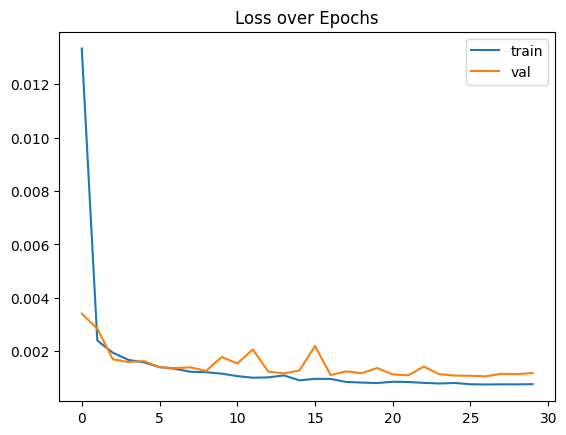

In [19]:
# 1. Set Params
params = {
    'epochs': 30,
    'batch_size': 32,
    'lstm_units': 50
}

# 2. Set Model Type: 'cnn_small', 'cnn_big', 'cnn_lstm_1'
model_type = 'cnn_small'

trained_model, history, run_id = train_model_with_mlflow(
                                                    X=X, 
                                                    y=y, 
                                                    X_val=X_val, 
                                                    y_val=y_val,
                                                    model_type=model_type,
                                                    params=params
                                                    )

# Load existing model

In [11]:
#model = mlflow.keras.load_model("runs:/<run_id>/model.keras")

# Forecasting

We run the forecasting, not in an autoregressive way, as this mostly gave a worse result. We have defined in the above function that we put a certain amount of days into the forecasting, by default it is three, and we have defined the size of our forecasting y that we expect to come out of it. 
As we do not know on which features our model is trained, we have to test out different input and output times for our model. 
In the below function, we run the forecast using our trained model, inverse scale our predicted values, since we rescaled them for the forecast and make some plots.  

In [24]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
####
# Helper Functions

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        start_forecast,
        fuel='e5',
        model= trained_model,
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''
    with mlflow.start_run(run_id=run_id):
        #make predictions
        y_pred_forecast = model.predict(X_forecast)
        #scale the predictions back to original scale
        y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=0, scaler=scaler)
    
        # reattach the datetime to prediction
        n_predictions = len(y_pred)
        start_datetime = pd.to_datetime(start_forecast)
        time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")
    
        #combine into a DataFrame
        y_pred_df = pd.DataFrame({
            "datetime": time_index,
            "Predicted E5": y_pred
        })
        #make datetime index
        y_pred_df.set_index('datetime', inplace=True)
    
        # Save forecast to file
        np.savetxt("forecast.csv", y_pred_df, delimiter=",") 
        mlflow.log_artifact("forecast.csv")
    
        mae = mean_absolute_error(y_test, y_pred)
        print("Forecast MSE:", mae)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
        mlflow.log_metric("test_mae", mae)
        mlflow.log_metric("test_mape", mape)
    
        #print y_pred to check if it looks as expected
        print(y_pred_df.head()) 
    
        # Plot
        # Set parameters
        colors = {
            "background": "#f9fcfc",
            "gridcolor": "#dcdbd9",
            "legendedge": "#dcdbd9",
            "legendface": "white",
            "legendcol": "black",
            "textcolor": "black"
        }

        # Create a figure and axis with custom size
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(test_df[fuel], label=f'True Test {fuel}', drawstyle='steps-post', linewidth=3) # line width
        plt.plot(y_pred_df, drawstyle='steps-post', linewidth=3)
        # Set grid with custom color
        ax.grid(True, color=colors["gridcolor"])
        # Change border (spine) colors
        for spine in ax.spines.values():
            spine.set_edgecolor(colors["gridcolor"])
        # Set title and labels
        ax.set_title("Fuel price prediction of one gas station", fontweight="bold", fontsize=18, color=colors["textcolor"])
        ax.set_xlabel("time", fontweight="bold", fontsize=16, color=colors["textcolor"])
        ax.set_ylabel(f"{fuel} price (€/l)", fontweight="bold", fontsize=16, color=colors["textcolor"])
        # Customize tick labels
        for label in ax.get_xticklabels():
            label.set_fontsize(16)
            label.set_color(colors["textcolor"])

        for label in ax.get_yticklabels():
            label.set_fontsize(16)
            label.set_color(colors["textcolor"])
            label.set_fontweight('normal')

        # Set background color
        ax.set_facecolor(colors["background"])
        fig.patch.set_facecolor(colors["background"])
        # Create legend
        plt.legend(fontsize=16,loc='upper right', 
                   edgecolor=params.get("legendedge"), 
                   facecolor=params.get("legendface"), 
                   labelcolor = params.get("legendcol"),
                   framealpha=1)
        plt.savefig("forecast.png", bbox_inches='tight', dpi=300, facecolor=colors["background"])
        mlflow.log_artifact("forecast.png")
        plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.023473977764176004
                     Predicted E5
datetime                         
2025-05-24 00:00:00      1.814388
2025-05-24 00:05:00      1.818522
2025-05-24 00:10:00      1.813204
2025-05-24 00:15:00      1.813748
2025-05-24 00:20:00      1.813337


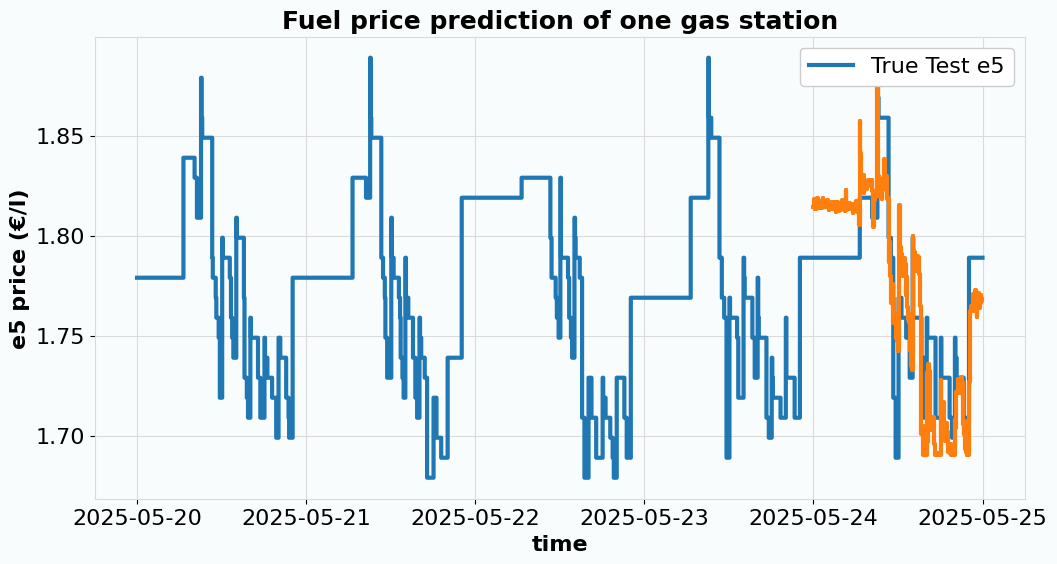

In [25]:
forecasting(X_forecast = X_forecast, scaled_train = scaled_train, scaler = scaler, start_forecast = start_forecast)



# End run

In [23]:
mlflow.end_run()

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".